<a href="https://colab.research.google.com/github/noemiezufferey/2024_Geoinformatique_I/blob/main/s4_ip_exercice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercice 4 - Fonction et calcul scientifique

## Numpy pour le calcul scientifique et Matplotlib

**Objectifs d'apprentissage**

* Créer de nouveaux tableaux en utilisant `linspace` et `arange`.
* Calculer des formules de base avec les tableaux `numpy`.
Charger des données à partir de fichiers `.npy` * Effectuer des réductions (par exemple `.npy`)
* Effectuer des réductions (par exemple `mean`, `std` sur les tableaux `numpy`)
* Réaliser des tracés linéaires 1D
* Réaliser des diagrammes de dispersion
* Annoter les graphiques avec des titres et des axes

Dans ce problème, nous utilisons des données réelles provenant de flotteurs de profilage océanique. Les flotteurs [ARGO](http://www.argo.ucsd.edu/) sont des instruments robotiques autonomes qui recueillent des données sur la température, la salinité et la pression de l'océan. Les flotteurs [ARGO](http://www.argo.ucsd.edu/) recueillent un "profil" (un ensemble de mesures à différentes profondeurs ou "niveaux").

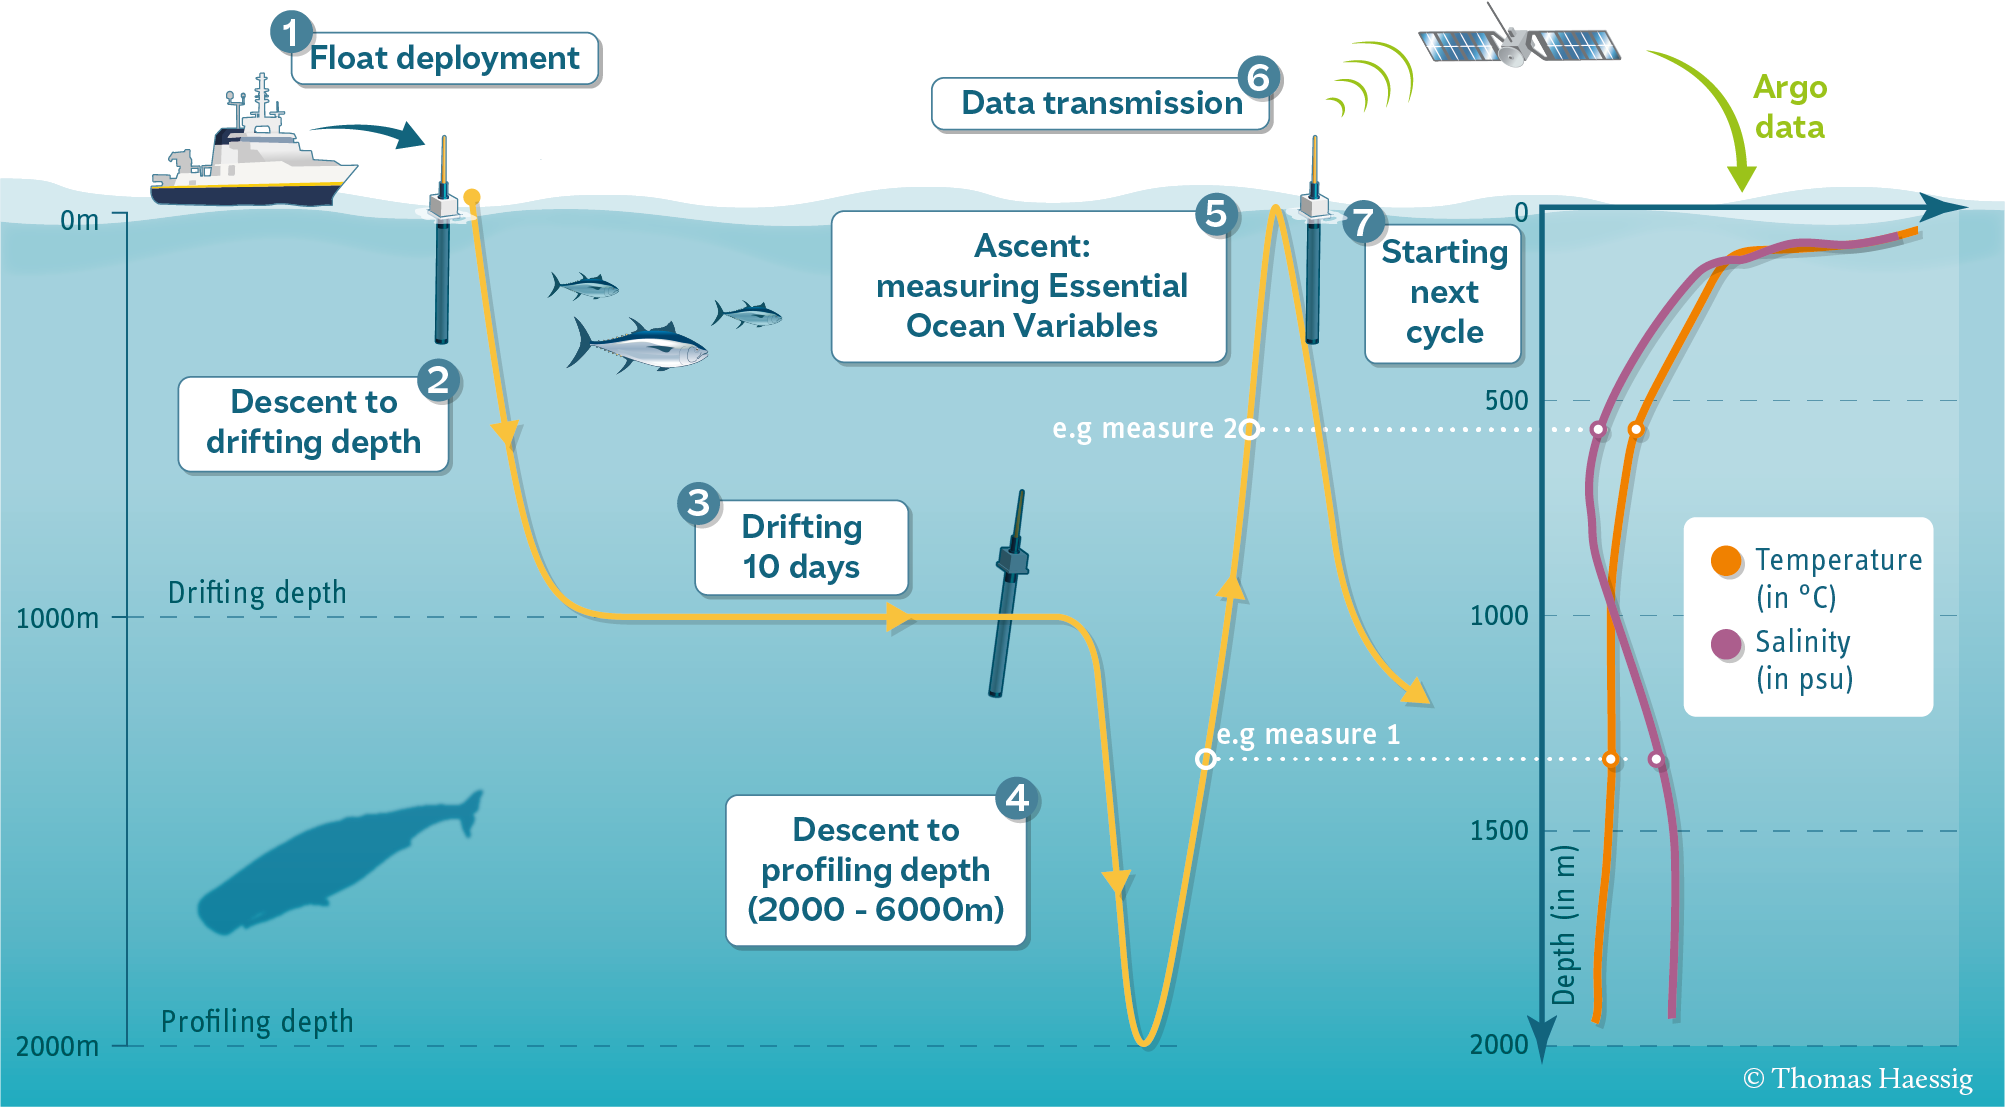


Chaque profil est associé à une latitude, une longitude et une date, ainsi qu'à de nombreux niveaux différents.

Commençons par utiliser [pooch](https://www.fatiando.org/pooch/latest/) pour télécharger les fichiers de données dont nous avons besoin pour cet exercice. Le code suivant vous donnera une liste de fichiers `.npy` que vous pourrez ouvrir à l'étape suivante.

In [ ]:
import pooch

url = "https://unils-my.sharepoint.com/:u:/g/personal/tom_beucler_unil_ch/EZwbaBqass1LhZO3DS3BCL0BhIlcENuoDItMB9b4IYDUCQ?download=1"
files = pooch.retrieve(url, processor=pooch.Unzip(), known_hash='2a703c720302c682f1662181d329c9f22f9f10e1539dc2d6082160a469165009')
files

Unzipping contents of '/root/.cache/pooch/4e2111f8c8dc35a2e2c0f9ec759ecb61-EZwbaBqass1LhZO3DS3BCL0BhIlcENuoDItMB9b4IYDUCQ' to '/root/.cache/pooch/4e2111f8c8dc35a2e2c0f9ec759ecb61-EZwbaBqass1LhZO3DS3BCL0BhIlcENuoDItMB9b4IYDUCQ.unzip'


['/root/.cache/pooch/4e2111f8c8dc35a2e2c0f9ec759ecb61-EZwbaBqass1LhZO3DS3BCL0BhIlcENuoDItMB9b4IYDUCQ.unzip/float_data/S.npy',
 '/root/.cache/pooch/4e2111f8c8dc35a2e2c0f9ec759ecb61-EZwbaBqass1LhZO3DS3BCL0BhIlcENuoDItMB9b4IYDUCQ.unzip/float_data/levels.npy',
 '/root/.cache/pooch/4e2111f8c8dc35a2e2c0f9ec759ecb61-EZwbaBqass1LhZO3DS3BCL0BhIlcENuoDItMB9b4IYDUCQ.unzip/float_data/date.npy',
 '/root/.cache/pooch/4e2111f8c8dc35a2e2c0f9ec759ecb61-EZwbaBqass1LhZO3DS3BCL0BhIlcENuoDItMB9b4IYDUCQ.unzip/float_data/lon.npy',
 '/root/.cache/pooch/4e2111f8c8dc35a2e2c0f9ec759ecb61-EZwbaBqass1LhZO3DS3BCL0BhIlcENuoDItMB9b4IYDUCQ.unzip/float_data/P.npy',
 '/root/.cache/pooch/4e2111f8c8dc35a2e2c0f9ec759ecb61-EZwbaBqass1LhZO3DS3BCL0BhIlcENuoDItMB9b4IYDUCQ.unzip/float_data/T.npy',
 '/root/.cache/pooch/4e2111f8c8dc35a2e2c0f9ec759ecb61-EZwbaBqass1LhZO3DS3BCL0BhIlcENuoDItMB9b4IYDUCQ.unzip/float_data/lat.npy']

In [ ]:
import numpy as np

**Q1) Chargez chaque fichier de données sous la forme d'un tableau `numpy`.**

Vous pouvez utiliser les noms que vous voulez pour vos tableaux, mais nous recommandons :

`T` : température

`S` : salinité

`P` : pression

`date` : date

`lat` : latitude

`lon` : longitude

`level` : niveau de profondeur

Astuce 1 : Regardez le nom du fichier (les éléments dans `files`) pour savoir quel fichier correspond à quelle variable.

Astuce 2 : Consultez la documentation de [`np.load`](https://numpy.org/doc/stable/reference/generated/numpy.load.html).

Affichez les noms des éléments des fichiers ici

In [ ]:
for file in files:
    print(file) # Add code to be executed for each file

/root/.cache/pooch/4e2111f8c8dc35a2e2c0f9ec759ecb61-EZwbaBqass1LhZO3DS3BCL0BhIlcENuoDItMB9b4IYDUCQ.unzip/float_data/S.npy
/root/.cache/pooch/4e2111f8c8dc35a2e2c0f9ec759ecb61-EZwbaBqass1LhZO3DS3BCL0BhIlcENuoDItMB9b4IYDUCQ.unzip/float_data/levels.npy
/root/.cache/pooch/4e2111f8c8dc35a2e2c0f9ec759ecb61-EZwbaBqass1LhZO3DS3BCL0BhIlcENuoDItMB9b4IYDUCQ.unzip/float_data/date.npy
/root/.cache/pooch/4e2111f8c8dc35a2e2c0f9ec759ecb61-EZwbaBqass1LhZO3DS3BCL0BhIlcENuoDItMB9b4IYDUCQ.unzip/float_data/lon.npy
/root/.cache/pooch/4e2111f8c8dc35a2e2c0f9ec759ecb61-EZwbaBqass1LhZO3DS3BCL0BhIlcENuoDItMB9b4IYDUCQ.unzip/float_data/P.npy
/root/.cache/pooch/4e2111f8c8dc35a2e2c0f9ec759ecb61-EZwbaBqass1LhZO3DS3BCL0BhIlcENuoDItMB9b4IYDUCQ.unzip/float_data/T.npy
/root/.cache/pooch/4e2111f8c8dc35a2e2c0f9ec759ecb61-EZwbaBqass1LhZO3DS3BCL0BhIlcENuoDItMB9b4IYDUCQ.unzip/float_data/lat.npy


Ensuite, chargez les fichiers sous forme de tableaux `numpy`, par exemple en utilisant la compréhension de liste

In [ ]:
#@title Code à compléter (au besoin)
S, levels, date, lon, P, T, lat = [np.load(files[i]) for i in range(7)]

**Q2) Recréez le tableau `level` en utilisant `np.arange` et `np.linspace`**.

Conseils :

* La documentation de `np.arange` est [at this link](https://numpy.org/devdocs/reference/generated/numpy.arange.html)
* La documentation pour `np.linspace` est [à ce lien](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html)
* La documentation pour `np.testing.assert_equal` est [at this link](https://numpy.org/doc/stable/reference/generated/numpy.testing.assert_equal.html)

Affichez le tableau `level` (niveau)

In [ ]:
import numpy as np

Recréez le tableau `level` en utilisant `np.arange` et l'appeler `level_arange`

In [ ]:
level_arange = np.arange(0,1000,10)
print("Level (arange):", level_arange)

Level (arange): [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710
 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890
 900 910 920 930 940 950 960 970 980 990]


In [ ]:
#@title Code à compléter (au besoin)
level_arange = np.arange(___,___)

Vérifiez que `level` et `level_arange` sont égaux en utilisant `np.testing.assert_equal`

In [ ]:
level = np.arange(0, 1000, 100)
level_arange = np.arange(0, 1000, 100)

In [ ]:
#@title Code à compléter (au besoin)
np.testing.assert_equal(level,level_arange)

Recréer le tableau `level` en utilisant `np.linspace` et l'appeler `level_linspace`

In [ ]:
level_linspace = np.linspace(0, 900, 10)
print("Level (linspace):", level_linspace)

Level (linspace): [  0. 100. 200. 300. 400. 500. 600. 700. 800. 900.]


In [ ]:
#@title Code à compléter (au besoin)
___ = np.___(___,___,___)

Vérifiez que `level` et `level_linspace` sont égaux en utilisant `np.testing.assert_equal`

In [ ]:
#@title Code à compléter (au besoin)
np.testing.assert_equal(level, level_linspace)

**Q3) Examinez les formes de `T`, `S` et `P` par rapport à `lon`, `lat`, `date` et `niveau`. Comment pensez-vous qu'ils sont liés ?**

Indice : consultez la sous-section [NDArrays](#NDArrays)

Affichez les formes de toutes les variables chargées

In [ ]:
S.shape # permet de connaître la dimension d'un tableau numpy (nombre de lignes, nombre de colonnes)


(78, 75)

In [ ]:
#@title Code à compléter (au besoin)
level.shape


(10,)

D'après les formes, quelles sont les dimensions partagées entre les tableaux ?

**Q4) En vous basant sur la formule ci-dessous, calculez la densité de l'eau de mer `relative_density`, par rapport à l'eau pure, en fonction de la température, de la salinité et de la pression.**

`densité_relative`$ = ρ -ρ_{Eau pure} = a \times S +b \times \Theta + c \times \Theta^{2}$

où :

* Les densités $\rho$ et $ρ_{Pure\ eau}$ sont exprimées en unités $kg/m^{3}$.
* Les constantes $a$, $b$ et $c$ sont fournies ci-dessous.
* La fonction permettant de calculer la température conservative $\Theta$ (en unités Celcius) à partir de la température, de la salinité et de la pression est fournie ci-dessous.
* La température $T$ est exprimée en unités Celcius.
* La salinité $S$ est exprimée en unités $g/kg$.
* La pression $p$ est exprimée en unités $dbar$.

Astuce : Les tableaux `numpy` chargés `temperature`, `salinity`, et `pressure` ont déjà les bonnes unités et aucune conversion n'est nécessaire.

Sources :

1) [*Roquet, Fabien, et al. "Defining a simplified yet "realistic" equation of state for seawater." Journal of Physical Oceanography 45.10 (2015) : 2564-2579.*](https://journals.ametsoc.org/view/journals/phoc/45/10/jpo-d-15-0080.1.xml)

2) [*The Gibbs SeaWater (GSW)
Oceanographic Toolbox of TEOS-10*](https://www.teos-10.org/pubs/gsw/html/gsw_front_page.html). (Licence)](https://www.teos-10.org/pubs/gsw/html/gsw_licence.html)

Voici les constantes a, b et c :

In [ ]:
a = 7.718e-1
b = -8.44e-2
c = -4.561e-3

Importons la bibliothèque [`gsw`] (https://teos-10.github.io/GSW-Python/) qui contient la fonction `CS_from_t` pour calculer la température conservative $\Theta$ à partir de la température, de la salinité et de la pression.

In [ ]:
!pip install gsw
from gsw import CT_from_t

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.2 MB/s eta 0:00:00


Maintenant, c'est à vous de jouer. Voici l'équation pour éviter d'avoir à faire défiler la page vers le haut :

`densité_relative`$ = ρ -ρ_{Pure\ Eau} = a \times S +b \times \Theta + c \times \Theta^{2}$

Calculeuz la température conservatrice

Conseil : utilisez [CT_from_t](https://www.teos-10.org/pubs/gsw/html/gsw_CT_from_t.html)

In [ ]:
#@title Code à compléter (au besoin)
def CT_from_t(SA,T,p):
    print("Conservative Temperature (CT):, CT")

Calculez la "densité relative" à l'aide de l'équation ci-dessus.

In [ ]:
densite_relative = a*S + b*CT + c*(CT**2)

NameError: name 'CT' is not defined

In [ ]:
#@title Code à compléter (au besoin)
___ = ___

**Q4) Faites un graphique pour chaque colonne de données dans `T`, `S`, `P`, et
`densité_relative` (quatre plots)**

Pour cette question, nous devons utiliser l'interface [Pyplot](https://matplotlib.org/stable/tutorials/introductory/pyplot.html) de la bibliothèque [Matplotlib](https://matplotlib.org/) pour la visualisation, même si nous ne l'avons pas encore étudiée en profondeur en classe. Mais n'ayez crainte, nous vous fournissons des instructions faciles à suivre ci-dessous. 😊

La première étape consiste à importer Pyplot. Il suffit d'exécuter le code ci-dessous.

In [ ]:
import matplotlib.pyplot as plt

Ensuite, nous tracerons les variables en fonction de la profondeur de l'océan, `level`. Il suffit de lire la documentation [sur ce lien] (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) pour en déduire la syntaxe correcte. Etiquetez vos axes en utilisant `plt.xlabel` et `plt.ylabel`, et ajoutez un titre en utilisant `plt.title`.

Astuce : L'échelle verticale doit utiliser les données `level` pour être cohérente avec les conventions océanographiques.

Conseil 2 : Chaque graphique doit avoir une ligne pour chaque colonne de données. Le résultat sera désordonné, comme dans le graphique ci-dessous :

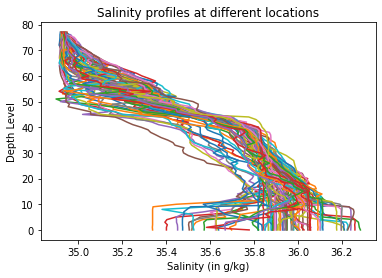

ValueError: x and y must have same first dimension, but have shapes (78, 75) and (10,)

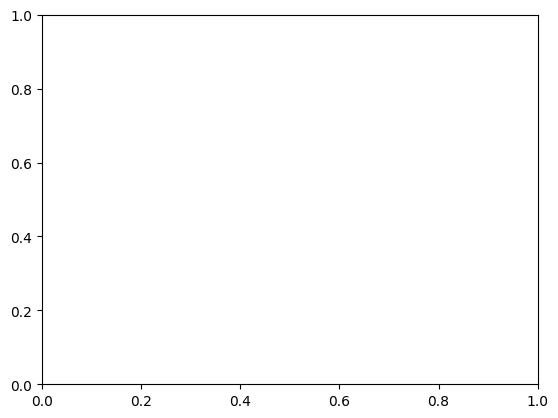

In [ ]:
plt.plot(S,level) ; # Le point-virgule empêche l'impression des objets de ligne
plt.xlabel('Salinity (in g/kg)') # Prend une chaîne de caractères comme argument
plt.ylabel('Depth Level')
plt.title('Salinity')

Faites plus de plots ci-dessous:

**Q5) Calculez la moyenne et l'écart-type de `T`, `S`, `P`, et `seawater_density` à chaque profondeur dans `level`.

Conseil : Vous pouvez lire la documentation sur [ce lien](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) et [ce lien](https://numpy.org/doc/stable/reference/generated/numpy.std.html).

Conseil 2 : Vous pouvez vérifier que vous avez pris la moyenne et les écarts types le long des axes corrects en vérifiant la "forme" de vos résultats.

Calculez les moyennes...

In [ ]:

P.shape

(78, 75)

In [ ]:
#@title Code à compléter (au besoin)
mean_T = np.mean(T,axis=1)
___
___
___

(78, 75)

... et les écarts types.

In [ ]:
std_T = np.std(T, axis=1)

In [ ]:
#@title Code à compléter (au besoin)
___ = ___.___(___,___)

Vérifiez qu'elles ont la même forme que vos coordonnées de niveau vertical `lev` :

In [ ]:
mean_T.shape

(78,)

In [ ]:
std_T.shape

(78,)

In [ ]:
level.shape

(10,)

In [ ]:
#@title Code à compléter (au besoin)
np.testing.assert_equal(___.shape,lev.shape)

**Q6) Faites maintenant des tracés similaires, mais ne montrez que les moyennes `T`, `S`, `P`, et `densité_de_l'eau_de_mer` à chaque profondeur. Faites apparaître les barres d'erreur sur chaque graphique en utilisant les écarts-types**.

Astuce : Si vous vous sentez aventureux, vous pouvez utiliser directement la fonction [`plt.errorbar`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html).

Astuce 2 : Vous devriez obtenir des graphiques similaires à celui ci-dessous

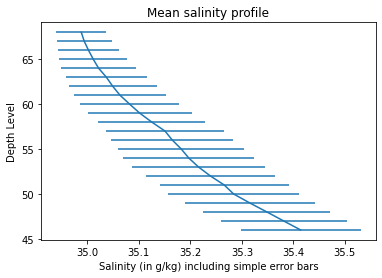

Text(0.5, 1.0, '(78,)')

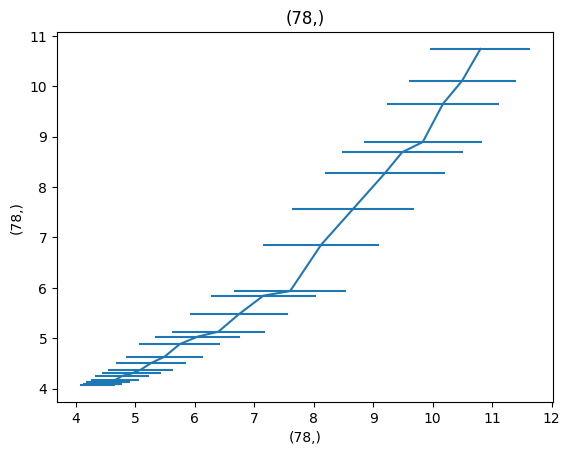

In [ ]:
plt.errorbar(mean_T,T[:,0],xerr=std_T)
plt.xlabel(___)
plt.ylabel(___)
plt.title(___)

Encore trois plots et nous serons prêts 🙂 .

**Q7) Prise en compte des données manquantes**

Les profils contiennent de nombreuses valeurs manquantes. Celles-ci sont indiquées par la valeur spéciale "Not a Number", ou `np.nan`.

Lorsque vous prenez la moyenne ou l'écart type des données contenant des NaN, le résultat entier devient `NaN`. Au lieu de cela, si vous utilisez les fonctions spéciales `np.nanmean` et `np.nanstd`, vous dites à NumPy d'ignorer les NaN.

Recalculez les moyennes et les écarts types comme dans les sections précédentes en utilisant ces fonctions et tracez les résultats.

Conseil : Liens vers la documentation [`np.nanmean`](https://numpy.org/doc/stable/reference/generated/numpy.nanmean.html) et la documentation [`np.nanstd`](https://numpy.org/doc/stable/reference/generated/numpy.nanstd.html).

Recalculez les moyennes ci-dessous en ignorant les valeurs manquantes. Nous espérons que vous pouvez maintenant trouver la syntaxe complète vous-même 😎

In [ ]:
namean_T = np.nanmean(T, axis=1)

De même, recalculez les écarts types en ignorant les valeurs manquantes.

**Q8) Créez un diagramme de dispersion des coordonnées longitudinales (`lon`) et latitudinales (`lat`) des flotteurs ARGO.**

Encore une fois, nous n'en avons pas parlé dans le tutoriel, mais il existe une fonction de diagramme de dispersion très pratique appelée [`plt.scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) fournie par l'interface Pyplot.

Bonus : Etiqueter votre figure en utilisant `plt.xlabel`, `plt.ylabel`, et `plt.title`.

Bonus 2 : Augmentez la taille de police de vos étiquettes en ajoutant un argument `fontsize=` aux fonctions d'étiquettes.

Bonus 3 : Rendez votre diagramme de dispersion plus beau en changeant les arguments de [`plt.scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) listés dans la documentation, par exemple `s=`.

In [ ]:
#@title Code à compléter (au besoin)
plt.scatter(___,___)
___ # Bonus
___ # Plus de bonus

## Fonctions

**Q1) Ecrivez une fonction pour convertir l'unité que vous avez choisie pour les masses planétaires en $M_{Terre}$, la masse de la Terre**.

Par exemple, la masse de Jupiter est :

$M_{Jupiter} \approx 1898\times10^{24}kg \approx 318 M_{Terre}$

In [ ]:
planetdict = {'mercure':0.330,'vénus':4.87,'terre':5.97,
              'mars':0.642,'jupiter':1898,'saturne':568,'uranus':86.8,'nepturne':102, 'pluto':0.013}

# unit: 10^24 kg

In [ ]:
# Ecrivez votre fonction ici
# La fonction doit prendre la masse de la planète que vous voulez (par exemple, planetdict['mars']) et la diviser par la masse de la Terre.
# (planetdict['terre'])
reponse = planetdict['jupiter'] / planetdict['terre']
print(reponse)
# Testez que cela fonctionne pour jupiter (planetdict['jupiter']), la fonction devrait retourner 317.92294807370183


317.92294807370183


In [ ]:
#@title Code à compléter (au besoin)
# Ecrivez votre fonction ici
# La fonction doit prendre la masse de la planète que vous voulez (par exemple, planetdict['mars']) et la diviser par la masse de la Terre.
# (planetdict['terre'])
def convert_mass_Mterre(______=____):
  return _________/planetdict['terre']

#tester que cela fonctionne pour jupiter (planetdict['jupiter']), la fonction devrait retourner 317.92294807370183
convert_mass_Mterre(____________)

**Q2) Ecrivez maintenant une fonction unique qui peut convertir l'unité que vous avez choisie pour les masses planétaires en $M_{Terre}$ ou $M_{Jupiter}$ selon le mot-clé que vous avez spécifié**.

In [ ]:
# Écrivez votre fonction ici
def masse_planet (planet, planet_ref):
  return planetdict[planet] / planetdict[planet_ref]
print(masse_planet('jupiter','jupiter'))
# Vérifiez que votre fonction fonctionne : convertissez Mjupiter en Mterre et Mjupiter,
# Vous devriez voir 317.923 (Mterre) et 1.0 (Mjupiter)

1.0


In [ ]:
#@title Code à compléter (au besoin)
# Écrivez votre fonction ici
def convert_m_Mterrejupiter(______=____,ourplanet='jupiter') :
  return ___________/planetdict[ourplanet]

# Vérifiez que votre fonction fonctionne : convertissez Mjupiter en Mterre et Mjupiter,
# Vous devriez voir 317.923 (Mterre) et 1.0 (Mjupiter)
print(convert_m_Mterrejupiter(planetdict['jupiter'],_____),convert_m_Mterrejupiter(planetdict['jupiter'],______))

In [ ]:
# Stocker le Mjupiter pour Q3
Mjupiter = convert_m_Mterrejupiter(planetdict['jupiter'], 'jupiter')

NameError: name 'convert_m_Mterrejupiter' is not defined

**Q3) Ecrivez une fonction qui prend un argument (la masse en $M_{Jupiter}$) et renvoie deux arguments (la masse en $M_{Terre}$ et la masse dans l'unité que vous avez choisie [la planète que vous voulez]).

In [ ]:
# Écrivez votre fonction ici
# Vérifiez que la conversion de la masse de Jupiter en $M_{Terre}$ et en $M_{Terre}$ fonctionne.
# l'unité choisie (par exemple, la planète Mars)

In [ ]:
#@title Code à compléter (au besoin)
# Écrivez votre fonction ici
def mass_conversion_two_arguments(mass,planet=____) :
  a = mass/planetdict[_____] # Terre
  b = mass/planetdict[______] # La planète que vous voulez utiliser comme référence
  return a,b
# Vérifiez que la conversion de la masse de Jupiter en $M_{Terre}$ et en $M_{Terre}$ fonctionne.
# l'unité choisie (par exemple, la planète Mars)
print(mass_conversion_two_arguments(_____,'mars'))

In [ ]:
# Bonus : Utilisez la fonction de Q10 pour convertir la masse de Neptune en $M_{Jupiter}$.
# puis la fonction de Q3 pour la reconvertir dans l'unité que vous avez choisie
# Retrouvez-vous la valeur originale ?

In [ ]:
!pip install pooch
import pooch
import zipfile
import os

# Définir l'URL et le chemin de destination
url = "https://files.swisscarto.ch/geoinf1/vd_dgav_surfaces_agricoles.zip"
destination = pooch.os_cache("geodata")  # Crée un dossier de cache pour stocker les fichiers

# Télécharger l'archive
filename = pooch.retrieve(url, known_hash=None, path=destination)

# Décompresser l'archive ZIP
with zipfile.ZipFile(filename, 'r') as zip_ref:
    # Extraire tous les fichiers dans le même répertoire que l'archive
    zip_ref.extractall(destination)

print(f"Les fichiers ont été extraits dans : {destination}")




SHA256 hash of downloaded file: 0d866067c647f235d92499e669b8dfb4dfea18da3cfd99434a7e6176a9fba81f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


Les fichiers ont été extraits dans : /root/.cache/geodata


In [ ]:
from google.colab import files

# Permet de télécharger un fichier depuis votre ordinateur
uploaded = files.upload()

# Afficher le nom des fichiers téléchargés
uploaded.keys()


Saving perimetre_ze_joint.gpkg to perimetre_ze_joint.gpkg


dict_keys(['perimetre_ze_joint.gpkg'])

In [ ]:
!pip install geopandas
from google.colab import files

# Télécharger le fichier depuis votre machine locale
uploaded = files.upload()

import geopandas as gpd

# Lire le fichier GeoPackage avec GeoPandas
gdf = gpd.read_file("vd_dgav_surfaces_agricoles/nom_du_fichier.gpkg", layer="agr_dgav_sau")

# Afficher les 5 premières lignes du DataFrame
gdf.head()



In [ ]:
import geopandas as gpd
import pandas as pd
import pooch
import os
from google.colab import files

# Télécharger et décompresser les données
url = 'https://files.swisscarto.ch/geoinf1/vd_dgav_surfaces_agricoles.zip'
data_files = pooch.retrieve(
    url=url,
    known_hash=None,
    processor=pooch.Unzip()
)

# Lire le fichier Geopackage avec les surfaces agricoles
sau_gpkg_path = [df for df in data_files if df.endswith('.gpkg')][0]
sau = gpd.read_file(sau_gpkg_path, layer='agr_dgav_sau')

# Télécharger le fichier de périmètre d'évaluation
uploaded = files.upload()

perimetre_evaluation_path = list(uploaded.keys())[0]
perimetre_evaluation = gpd.read_file(perimetre_evaluation_path)

from google.colab import files
uploaded = files.upload()  # Uploader le fichier .shp et ses fichiers connexes

# Vérifier les fichiers uploadés
print(uploaded.keys())

# Extraire le fichier shapefile s'il est compressé dans une archive .zip
import zipfile
with zipfile.ZipFile("Zone_de_risque.zip", "r") as zip_ref:
    zip_ref.extractall("temp_shapefile")

# Lire le fichier shapefile extrait
perimetre_evaluation = gpd.read_file("temp_shapefile/Zone_de_risque.shp")


# Vérifier les systèmes de coordonnées et les harmoniser si nécessaire
if sau.crs != perimetre_evaluation.crs:
    perimetre_evaluation = perimetre_evaluation.to_crs(sau.crs)

# Faire une extraction des polygones des surfaces agricoles utiles qui intersectent avec le périmètre d'évaluation
sau_intersect = gpd.overlay(sau, perimetre_evaluation, how='intersection')

# Vérifier le résultat en l'affichant sur une carte
sau_intersect.plot()

# Lire le fichier CSV avec les informations d'utilisation
csv_path = [df for df in data_files if df.endswith('.csv')][0]
sau_util = pd.read_csv(csv_path)

# Afficher les premières lignes des deux jeux de données pour identifier les colonnes correspondantes
print(sau_intersect.head())
print(sau_util.head())

# Faire une jointure par attributs pour rajouter les informations du fichier CSV dans le DataFrame de GeoPandas
sau_data = sau_intersect.merge(sau_util, left_on='ident', right_on='IDENT', how='left')

# Calculer la superficie de chaque surface agricole en hectares
sau_data['superficie_ha'] = sau_data['geometry'].area / 10000

# Faire un résumé des surfaces totales par utilisation
sau_area_par_classe = sau_data.groupby('UTILISATIO')['superficie_ha'].sum().reset_index()

# Sauvegarder le résumé des surfaces totales par utilisation dans un fichier CSV
sau_area_par_classe.to_csv('resume_surfaces_agricoles.csv', index=False)

# Supprimer la colonne 'IDENT' pour éviter les conflits de noms de colonnes
del sau_data['IDENT']

# Sauvegarder la version modifiée du DataFrame GeoPandas avec les surfaces agricoles dans un fichier Geopackage
sau_data.to_file('surfaces_agricoles_utilisation.gpkg', driver='GPKG', layer='surfaces_agricoles_utilisation')

# Télécharger les fichiers depuis Google Colab
files.download('resume_surfaces_agricoles.csv')
files.download('surfaces_agricoles_utilisation.gpkg')



Saving perimetre_evaluation.shp to perimetre_evaluation.shp


DataSourceError: Unable to open perimetre_evaluation.shx or perimetre_evaluation.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.

In [1]:
import geopandas as gpd
import pandas as pd
import pooch
import os
from google.colab import files


In [2]:
# Télécharger et décompresser les données
url = 'https://files.swisscarto.ch/geoinf1/vd_dgav_surfaces_agricoles.zip'
data_files = pooch.retrieve(
    url=url,
    known_hash=None,
    processor=pooch.Unzip()
)


SHA256 hash of downloaded file: 0d866067c647f235d92499e669b8dfb4dfea18da3cfd99434a7e6176a9fba81f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
Unzipping contents of '/root/.cache/pooch/26d2db3ccf4efc592af4b57a09f55371-vd_dgav_surfaces_agricoles.zip' to '/root/.cache/pooch/26d2db3ccf4efc592af4b57a09f55371-vd_dgav_surfaces_agricoles.zip.unzip'


In [ ]:
# Lire le fichier Geopackage avec les surfaces agricoles
sau_gpkg_path = [df for df in data_files if df.endswith('.gpkg')][0]
sau = gpd.read_file(sau_gpkg_path, layer='agr_dgav_sau')


In [3]:
# Télécharger le fichier de périmètre d'évaluation
uploaded = files.upload()
perimetre_evaluation_path = list(uploaded.keys())[0]
perimetre_evaluation = gpd.read_file(perimetre_evaluation_path)


KeyboardInterrupt: 

In [11]:
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.ops import unary_union

In [12]:
# 1. Création des périmètres de 500 m, 1 km, et 5 km
# Charger le GeoPackage et la couche de la zone industrielle
zone_industrielle = gpd.read_file(r"/content/geoinf-proj-ze-9933.gpkg")

In [13]:
# Créer les zones tampons pour chaque périmètre
zi_500m = zone_industrielle.buffer(500)
zi_1km = zone_industrielle.buffer(1000)
zi_5km = zone_industrielle.buffer(5000)


In [14]:
# Fusionner les zones tampons pour chaque périmètre
zi_500m = unary_union(zi_500m)
zi_1km_diff = unary_union(zi_1km).difference(zi_500m)
zi_5km_diff = unary_union(zi_5km).difference(zi_1km)


In [15]:
# Créer un dictionnaire avec les zones tampon
zi_buf = {
    '500m': zi_500m,
    '1km': zi_1km_diff,
    '5km': zi_5km_diff
}


In [16]:
# Vérification du type de géométrie
for k, poly in zi_buf.items():
    print(f"Type de géométrie pour {k}: {type(poly)}")


Type de géométrie pour 500m: <class 'shapely.geometry.polygon.Polygon'>
Type de géométrie pour 1km: <class 'shapely.geometry.polygon.Polygon'>
Type de géométrie pour 5km: <class 'geopandas.geoseries.GeoSeries'>


In [17]:
from shapely.ops import unary_union
import geopandas as gpd

# Fusionner les polygones de 5 km (si nécessaire)
if isinstance(zi_5km_diff, gpd.GeoSeries):  # Vérifier si c'est une GeoSeries
    zi_5km_diff = unary_union(zi_5km_diff)  # Fusionner les polygones

# Vérifier les types après fusion
for k, poly in zi_buf.items():
    print(f"Type de géométrie pour {k}: {type(poly)}")

# Créer les GeoDataFrame après la fusion
zi_buf_clean = {
    k: gpd.GeoDataFrame(geometry=[poly], crs='EPSG:2056') if isinstance(poly, Polygon) else gpd.GeoDataFrame(geometry=[unary_union(poly)], crs='EPSG:2056')
    for k, poly in zi_buf.items()
}

# Vérifier les GeoDataFrames créés
for k, gdf in zi_buf_clean.items():
    print(f"GeoDataFrame pour {k}: {gdf.geometry.geom_type.unique()}")


Type de géométrie pour 500m: <class 'shapely.geometry.polygon.Polygon'>
Type de géométrie pour 1km: <class 'shapely.geometry.polygon.Polygon'>
Type de géométrie pour 5km: <class 'geopandas.geoseries.GeoSeries'>
GeoDataFrame pour 500m: ['Polygon']
GeoDataFrame pour 1km: ['Polygon']
GeoDataFrame pour 5km: ['Polygon']


In [18]:
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
import geopandas as gpd

# Vérifier et fusionner chaque zone tampon si nécessaire
for k, poly in zi_buf.items():
    if isinstance(poly, gpd.GeoSeries):  # Si c'est une GeoSeries, fusionner
        zi_buf[k] = unary_union(poly)
    elif isinstance(poly, (Polygon, MultiPolygon)):  # Si c'est un objet Shapely, continuer
        zi_buf[k] = poly
    else:
        print(f"Type inattendu pour {k}: {type(poly)}")


In [19]:
# Créer des GeoDataFrame pour chaque zone tampon
zi_buf_clean = {
    k: gpd.GeoDataFrame(geometry=[poly], crs='EPSG:2056')  # Convertir en GeoDataFrame
    for k, poly in zi_buf.items()
}

# Vérifier les GeoDataFrame créés
for k, gdf in zi_buf_clean.items():
    print(f"GeoDataFrame pour {k} : {gdf.geometry.geom_type.unique()}")


GeoDataFrame pour 500m : ['Polygon']
GeoDataFrame pour 1km : ['Polygon']
GeoDataFrame pour 5km : ['Polygon']


In [20]:
# Vérifier les GeoDataFrame résultants
for k, gdf in zi_buf_clean.items():
    print(f"Zone tampon {k}:")
    print(gdf)
    print(f"Type de géométrie : {gdf.geometry.geom_type.unique()}")


Zone tampon 500m:
                                            geometry
0  POLYGON ((2537398.342 1158479.615, 2537408.841...
Type de géométrie : ['Polygon']
Zone tampon 1km:
                                            geometry
0  POLYGON ((2536925.745 1158655.603, 2536956.005...
Type de géométrie : ['Polygon']
Zone tampon 5km:
                                            geometry
0  POLYGON ((2533020.523 1159506.446, 2533026.353...
Type de géométrie : ['Polygon']


In [21]:
import geopandas as gpd

# Chemin vers le GeoPackage
geopackage_path = r"/content/swissBOUNDARIES3D_1_5_LV95_LN02.gpkg"  # Remplacez par le chemin réel vers votre fichier GeoPackage

# Charger la couche des communes
communes = gpd.read_file(geopackage_path, layer="tlm_hoheitsgebiet")

# Vérifier le contenu des données
print(communes.head())  # Affiche les premières lignes des données
print(f"CRS : {communes.crs}")  # Affiche le système de coordonnées actuel


                                     uuid datum_aenderung datum_erstellung  \
0  {5D7E5812-120E-491A-BFCD-CCED809316F4}      2023-11-08       2008-11-24   
1  {72947F82-8AB3-4334-AFC5-08B4FB50FEFC}      2023-11-07       2008-11-24   
2  {D0755E75-03C7-4185-B46C-26A6C46239BB}      2023-10-24       2008-11-24   
3  {993CEB7E-AF34-4056-916D-B4D5D3233716}      2023-11-07       2008-11-24   
4  {F1F1C98A-F1FF-4A05-9EF3-9B07C13D0F06}      2023-11-08       2008-11-24   

   erstellung_jahr  erstellung_monat grund_aenderung   herkunft  \
0             1997                 1      Verbessert  swisstopo   
1             2000                 1      Verbessert  swisstopo   
2             2006                 1      Verbessert  swisstopo   
3             2000                 1      Verbessert  swisstopo   
4             1997                 1      Verbessert  swisstopo   

   herkunft_jahr  herkunft_monat  revision_jahr  ...  bezirksnummer  \
0           2024               1           2024  ...     

In [22]:
# Vérifier et aligner le CRS
if communes.crs != "EPSG:2056":
    communes = communes.to_crs("EPSG:2056")


In [23]:
# Intersection des zones tampon avec les communes
zi_buf_cmnes = {
    k: gpd.overlay(zi_gdf, communes, how='intersection')
    for k, zi_gdf in zi_buf_clean.items()  # Utiliser zi_buf_clean généré précédemment
}


                                     uuid datum_aenderung datum_erstellung  \
0  {711AB9D3-BE76-4DF6-BB85-AF8BA3EE531C}      2023-11-08       2008-11-24   
1  {FA8F5DEB-65A9-45CF-9510-3BC84A782842}      2023-10-24       2008-11-24   
2  {C47941E0-223D-4A70-A15E-DD8489E301D4}      2023-10-24       2008-11-24   
3  {5E6836AB-0BCD-473E-8323-C69E1604F0E3}      2023-10-24       2008-11-24   

   erstellung_jahr  erstellung_monat grund_aenderung   herkunft  \
0             2006                 1      Verbessert  swisstopo   
1             2006                 1      Verbessert  swisstopo   
2             2006                 1      Verbessert  swisstopo   
3             2006                 1      Verbessert  swisstopo   

   herkunft_jahr  herkunft_monat  revision_jahr  ...  bezirksnummer  \
0           2024               1           2024  ...         2223.0   
1           2024               1           2024  ...         2225.0   
2           2024               1           2024  ...        

<Axes: >

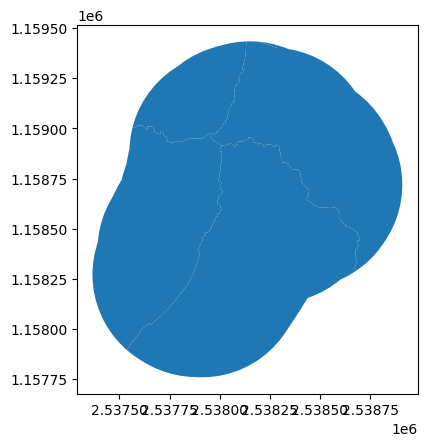

In [24]:
# Vérification pour une zone tampon (500m par exemple)
print(zi_buf_cmnes['500m'].head())

# Afficher la zone tampon intersectée avec les communes
zi_buf_cmnes['500m'].plot()


In [25]:
# Vérifiez les colonnes disponibles
print(zi_buf_cmnes['500m'].columns)


Index(['uuid', 'datum_aenderung', 'datum_erstellung', 'erstellung_jahr',
       'erstellung_monat', 'grund_aenderung', 'herkunft', 'herkunft_jahr',
       'herkunft_monat', 'revision_jahr', 'revision_monat',
       'revision_qualitaet', 'objektart', 'bfs_nummer', 'bezirksnummer',
       'kantonsnummer', 'name', 'gem_flaeche', 'see_flaeche', 'icc', 'shn',
       'einwohnerzahl', 'hist_nr', 'geometry'],
      dtype='object')


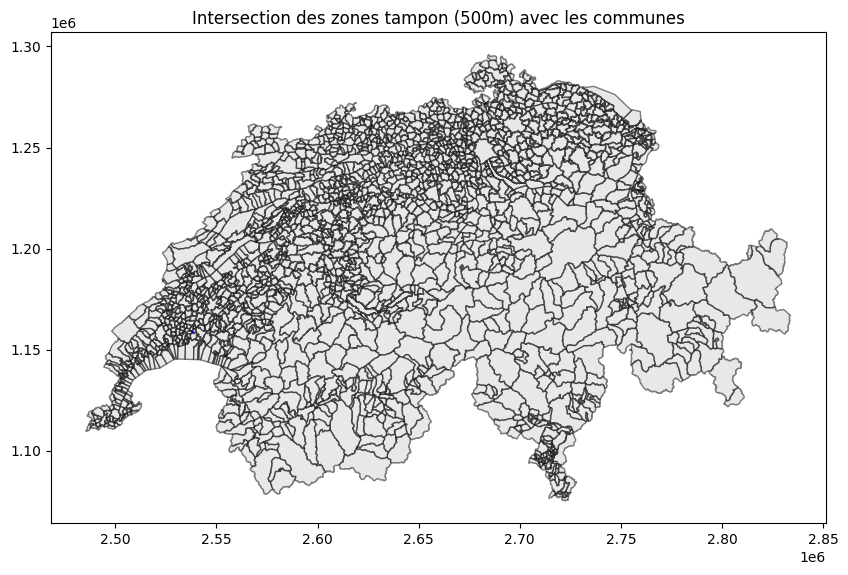

In [26]:
# Visualisation d'une zone tampon (500m) avec les communes
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
communes.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.5)
zi_buf_cmnes['500m'].plot(ax=ax, color="blue", alpha=0.7)
plt.title("Intersection des zones tampon (500m) avec les communes")
plt.show()


In [27]:
# Charger les couches
# Charger les données de population et d'emplois
population_points = gpd.read_file("/content/ofs_geostat.gpkg")
employment_points = gpd.read_file("/content/ofs_geostat.gpkg")

# Vérifier le CRS et l'aligner si nécessaire
if population_points.crs != "EPSG:2056":
    population_points = population_points.to_crs("EPSG:2056")

if employment_points.crs != "EPSG:2056":
    employment_points = employment_points.to_crs("EPSG:2056")


/usr/local/lib/python3.10/dist-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'ofs_geostat.gpkg': 'ofs_geostat' (default), 'pop_2023', 'empl_2022'. Specify layer parameter to avoid this warning.
  result = read_func(
/usr/local/lib/python3.10/dist-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'ofs_geostat.gpkg': 'ofs_geostat' (default), 'pop_2023', 'empl_2022'. Specify layer parameter to avoid this warning.
  result = read_func(


In [28]:
# Définir les couches car stockées dans un même Geopackage
import geopandas as gpd

# Chemin vers le GeoPackage
geopackage_path = "/content/ofs_geostat.gpkg"

# Charger la couche des points de population
population_points = gpd.read_file(geopackage_path, layer="pop_2023")

# Charger la couche des points d'emploi
employment_points = gpd.read_file(geopackage_path, layer="empl_2022")


In [29]:
# Charger les 2 couches
import geopandas as gpd

# Charger la couche des points de population
population_points = gpd.read_file(geopackage_path, layer="pop_2023")

# Charger la couche des points d'emploi
employment_points = gpd.read_file(geopackage_path, layer="empl_2022")


In [30]:
#Définir la fonction de jointure spatiale et de résumé
def sjoin_summarize(poly_lyr, pts_lyr, pts_colname, poly_newcolname):
    """
    poly_lyr:         GeoDataFrame contenant les polygones
    pts_lyr:          GeoDataFrame contenant les points
    pts_colname:      Nom de la colonne à sommer (population ou emplois)
    poly_newcolname:  Nom de la nouvelle colonne créée dans poly_lyr
    """
    # Jointure spatiale pour associer chaque point à un polygone
    sjoin = pts_lyr.sjoin(poly_lyr, how='inner', predicate='within')

    # Calcul de la somme par polygone
    somme_par_poly = sjoin.groupby(sjoin.index_right)[pts_colname].sum()

    # Ajout de la somme dans poly_lyr
    poly_lyr[poly_newcolname] = poly_lyr.index.map(somme_par_poly)


In [31]:
# Appliquer la fonction pour chaque zone tampon
for k, gdf in zi_buf_cmnes.items():
    # Calcul des habitants
    sjoin_summarize(gdf, population_points, pts_colname='BBTOT', poly_newcolname='pop_2023_sum')

    # Calcul des emplois
    sjoin_summarize(gdf, employment_points, pts_colname='B08EMPT', poly_newcolname='empl_2022_sum')

    # Ajouter la colonne 'peri' pour identifier la zone tampon
    gdf['peri'] = k


In [32]:
# Extraire les colonnes nécessaires
data_500m = zi_buf_cmnes['500m'][['bfs_nummer', 'name', 'peri', 'pop_2023_sum', 'empl_2022_sum']]
data_1km = zi_buf_cmnes['1km'][['bfs_nummer', 'name', 'peri', 'pop_2023_sum', 'empl_2022_sum']]
data_5km = zi_buf_cmnes['5km'][['bfs_nummer', 'name', 'peri', 'pop_2023_sum', 'empl_2022_sum']]


In [33]:
# Concaténer les donéées: combinaison des 3 DataFrames en un seul
import pandas as pd

final_data = pd.concat([data_500m, data_1km, data_5km], ignore_index=True)


In [34]:
# Remplacer les valeurs NaN par 0
final_data.fillna(0, inplace=True)


In [35]:
# Afficher le tableau
print(final_data)


    bfs_nummer                   name  peri  \
0         5527           Morrens (VD)  500m   
1         5586               Lausanne  500m   
2         5516              Cugy (VD)  500m   
3         5587   Le Mont-sur-Lausanne  500m   
4         5527           Morrens (VD)   1km   
5         5586               Lausanne   1km   
6         5516              Cugy (VD)   1km   
7         5587   Le Mont-sur-Lausanne   1km   
8         5592   Romanel-sur-Lausanne   1km   
9         5582  Cheseaux-sur-Lausanne   5km   
10        5473               Boussens   5km   
11        5515   Bretigny-sur-Morrens   5km   
12        5521             Etagnières   5km   
13        5584              Epalinges   5km   
14        5651   Villars-Sainte-Croix   5km   
15        5527           Morrens (VD)   5km   
16        5501                Sullens   5km   
17        5523            Froideville   5km   
18        5589                 Prilly   5km   
19        5586               Lausanne   5km   
20        551

In [36]:
# Corrections du tableau
# Vérifier si les colonnes contiennent des valeurs non numériques
print(final_data['pop_2023_sum'].apply(lambda x: isinstance(x, (int, float))).value_counts())
print(final_data['empl_2022_sum'].apply(lambda x: isinstance(x, (int, float))).value_counts())


pop_2023_sum
False    28
True      2
Name: count, dtype: int64
empl_2022_sum
False    28
True      2
Name: count, dtype: int64


In [37]:
final_data['pop_2023_sum'] = pd.to_numeric(final_data['pop_2023_sum'], errors='coerce')
final_data['empl_2022_sum'] = pd.to_numeric(final_data['empl_2022_sum'], errors='coerce')
final_data.fillna(0, inplace=True)


In [38]:
# Remplacer les NaN par 0
final_data.fillna(0, inplace=True)


In [39]:
print(final_data)


    bfs_nummer                   name  peri   pop_2023_sum  empl_2022_sum
0         5527           Morrens (VD)  500m   1.821500e+04   4.417700e+04
1         5586               Lausanne  500m   3.300000e+01   1.185742e+06
2         5516              Cugy (VD)  500m   5.131763e+42   4.444844e+12
3         5587   Le Mont-sur-Lausanne  500m   6.433333e+23   2.745961e+74
4         5527           Morrens (VD)   1km   3.111316e+10   4.000000e+00
5         5586               Lausanne   1km   1.183000e+03   1.144000e+03
6         5516              Cugy (VD)   1km   8.107733e+74   4.449443e+30
7         5587   Le Mont-sur-Lausanne   1km   6.665149e+25   4.646118e+11
8         5592   Romanel-sur-Lausanne   1km   0.000000e+00   0.000000e+00
9         5582  Cheseaux-sur-Lausanne   5km  3.452853e+222  4.445649e+108
10        5473               Boussens   5km   4.101926e+68   4.444925e+29
11        5515   Bretigny-sur-Morrens   5km   6.630322e+71   4.444444e+30
12        5521             Etagnières 

In [40]:
# Vérification des colonnes et des types
print(final_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bfs_nummer     30 non-null     int32  
 1   name           30 non-null     object 
 2   peri           30 non-null     object 
 3   pop_2023_sum   30 non-null     float64
 4   empl_2022_sum  30 non-null     float64
dtypes: float64(2), int32(1), object(2)
memory usage: 1.2+ KB
None


In [41]:
# Calcul des personnes selon les formules OPAM
# Appliquer les formules pour chaque période. Remplacez les formules par celles de l'OPAM.
final_data['Njsem'] = final_data['pop_2023_sum'] * 0.7  # Exemple, ajuster la formule OPAM
final_data['Nnsem'] = final_data['pop_2023_sum'] * 0.3  # Exemple, ajuster la formule OPAM
final_data['Njwe'] = final_data['pop_2023_sum'] * 0.5  # Exemple, ajuster la formule OPAM
final_data['Nnwe'] = final_data['pop_2023_sum'] * 0.5  # Exemple, ajuster la formule OPAM


In [47]:
# Spécifiez le chemin avec le nom du fichier CSV
output_path = r"C:\Users\noemi\Documents\sig\proj-sig-1\resultats\personnes_par_peri_et_cmne.csv"
# Sauvegarder le DataFrame dans un fichier CSV
final_data.to_csv(output_path, index=False)


In [51]:
import os
import pandas as pd

# Exemple de données (remplacez par vos données réelles)
final_data = pd.DataFrame({'col1': [1, 2, 3], 'col2': ['a', 'b', 'c']})

# Spécifiez un chemin complet valide pour le fichier
output_path = r'C:\Users\noemi\Documents\sig\proj-sig-1\resultats\personnes_par_peri_et_cmne.csv'

# Vérifiez si le chemin est valide
if not output_path:
    raise ValueError("Le chemin du fichier est vide. Vérifiez la variable 'output_path'.")

# Récupérez le répertoire parent
directory = os.path.dirname(output_path)

# Vérifiez si le répertoire parent existe et créez-le si nécessaire
if directory and not os.path.exists(directory):
    print(f"Le répertoire '{directory}' n'existe pas. Création...")
    os.makedirs(directory)

# Essayez de sauvegarder le fichier CSV
try:
    final_data.to_csv(output_path, index=False)
    print(f"Fichier enregistré avec succès : {output_path}")

    # Vérifiez si le fichier a bien été enregistré
    if os.path.exists(output_path):
        print(f"Le fichier a été trouvé à l'emplacement attendu : {output_path}")
    else:
        print("Le fichier n'a pas été trouvé après l'enregistrement. Problème inconnu.")

except Exception as e:
    print(f"Une erreur est survenue lors de l'enregistrement : {e}")


Fichier enregistré avec succès : C:\Users\noemi\Documents\sig\proj-sig-1\resultats\personnes_par_peri_et_cmne.csv
Le fichier a été trouvé à l'emplacement attendu : C:\Users\noemi\Documents\sig\proj-sig-1\resultats\personnes_par_peri_et_cmne.csv


In [ ]:
# Sélectionner les colonnes pertinentes pour l'agrégation par périmètre
data_peri = final_data[['peri', 'Njsem', 'Nnsem', 'Njwe', 'Nnwe']]

# Agrégation par périmètre
data_peri_agg = data_peri.groupby('peri', as_index=False).sum()

# Sauvegarder l'agrégation dans un fichier CSV
data_peri_agg.to_csv(r'C:\Users\noemi\Documents\sig\proj-sig-1\resultats\personnes_par_peri_et_cmne.csv', index=False)


In [ ]:
# Sélectionner les colonnes pertinentes pour l'agrégation par périmètre
data_peri = final_data[['peri', 'Njsem', 'Nnsem', 'Njwe', 'Nnwe']]

# Agrégation par périmètre
data_peri_agg = data_peri.groupby('peri', as_index=False).sum()

# Sauvegarder l'agrégation dans un fichier CSV
data_peri_agg.to_csv(r'C:\Users\noemi\Documents\sig\proj-sig-1\resultats\personnes_par_peri_et_cmne.csv', index=False)


In [ ]:
# Sélectionner les colonnes pertinentes pour l'agrégation par commune
data_cmne = final_data[['bfs_nummer', 'name', 'Njsem', 'Nnsem', 'Njwe', 'Nnwe']]

# Agrégation par commune (groupby sur bfs_nummer et name)
data_cmne_agg = data_cmne.groupby(['bfs_nummer', 'name'], as_index=False).sum()

# Sauvegarder l'agrégation par commune dans un fichier CSV
data_cmne_agg.to_csv(r'C:\Users\noemi\Documents\sig\proj-sig-1\resultats\personnes_par_peri_et_cmne.csv', index=False)
